In [423]:
# import libraries
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
import random
import matplotlib.pyplot as plt

# this is to mimic ggplot
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

green_fill = '#DAF2C2'
red_fill = '#FEB3B5'

# Load Data and Create Network

In [424]:
# now let's iterate through our amicus briefs and store the lexisCite, position, and amicus name
# data from https://amicispace.ucmerced.edu/data
amicus_briefs_csv = pd.read_csv("amicus_briefs.csv", encoding="latin")
amicus_briefs_csv = amicus_briefs_csv[["LexisCite", "Position", "AmicusName"]]
amicus_briefs_csv.head(5)

,LexisCite,Position,AmicusName
0,1953 U.S. LEXIS 2673,1,SECURITIES AND EXCHANGE COMMISSION
1,1953 U.S. LEXIS 2680,2,BOSTON AMERICAN LEAGUE BASE BALL COMPANY
2,1954 U.S. LEXIS 2094,1,AMERICAN FEDERATION OF TEACHERS
3,1954 U.S. LEXIS 2094,1,UNITED STATES
4,1954 U.S. LEXIS 2094,1,AMERICAN JEWISH CONGRESS


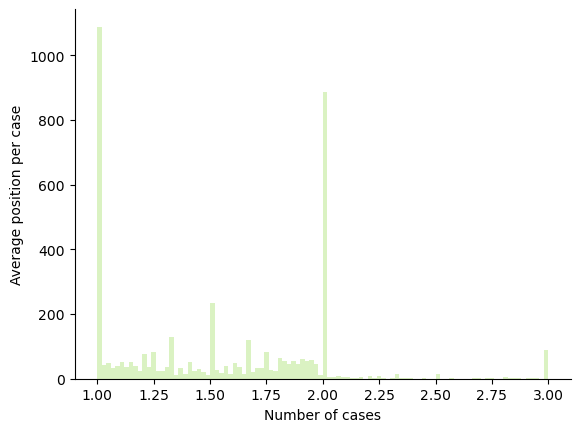

In [425]:
plt.hist(amicus_briefs_csv.groupby("LexisCite")["Position"].mean(), bins=100, color=green_fill)
plt.ylabel("Average position per case")
plt.xlabel("Number of cases")
plt.savefig('./plots/average_position_distribution.pdf',  bbox_inches='tight');

In [426]:
# some perfect duplicates -- drop?
amicus_briefs_csv.duplicated().mean()

0.007130397137654863

In [427]:
# drop perfect duplicates
amicus_briefs_csv = amicus_briefs_csv.drop_duplicates()

In [428]:
# position variable in amicus briefs
# = 1 if the brief argues the lower court decision should be reversed
# = 2 if lower court decision should be affirmed
# = 3 if the brief explicitly does not adopt a position or the position is unclear
amicus_briefs_csv["Position"].value_counts().sort_index()

Position
1    36942
2    38977
3     2058
Name: count, dtype: int64

In [429]:
amicus_briefs_csv["Position"].isna().mean()  # no missing values!

0.0

In [430]:
# let's now get the justices and their votes for each case (identified by LexisCite and caseName)
# data from http://scdb.wustl.edu/documentation.php
justices_csv = pd.read_csv("justices.csv", encoding="latin")
justices_csv.columns

C:\Users\Jennah\AppData\Local\Temp\ipykernel_42888\56783121.py:3: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  justices_csv = pd.read_csv("justices.csv", encoding="latin")


Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
       'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitioner', 'petitionerState', 'respondent',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes', 'justice', 'justiceName', 'vote',
       'opinion', 'direction', 'majority', 'firstA

In [431]:
[x for x in justices_csv.columns if "direction" in x.lower()]

['lcDispositionDirection',
 'decisionDirection',
 'decisionDirectionDissent',
 'direction']

In [432]:
justices_csv = justices_csv[
    [
        "lexisCite",
        "justiceName",
        "vote",
        "caseName",
        "caseDisposition",
        "lcDispositionDirection",
        "decisionDirection",
        "direction",
    ]
]
justices_csv.head(5)

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
0,1946 U.S. LEXIS 1724,HHBurton,2.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,1.0
1,1946 U.S. LEXIS 1724,RHJackson,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
2,1946 U.S. LEXIS 1724,WODouglas,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
3,1946 U.S. LEXIS 1724,FFrankfurter,4.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
4,1946 U.S. LEXIS 1724,SFReed,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0


In [433]:
# drop perfect duplicates
justices_csv = justices_csv.drop_duplicates()

In [434]:
# note the values of votes:
# Values:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote
justices_csv["vote"].value_counts().sort_index()

vote
1.0    57671
2.0    14056
3.0     3039
4.0     3627
5.0      256
6.0       20
7.0      390
8.0      924
Name: count, dtype: int64

In [435]:
justices_csv["caseName"].unique().shape[0]

8907

In [436]:
justices_csv[
    "vote"
].isna().mean()  # votes are missing in about 2% of cases -- should we drop these?

0.024680819930005975

In [437]:
# direction is the "Direction of the Individual Justice's Votes"
# 1 = conservative
# 2 = liberal
justices_csv["direction"].value_counts().sort_index()

direction
1.0    36635
2.0    40699
Name: count, dtype: int64

In [438]:
# This variable specifies whether the decision of the court whose decision the Supreme Court reviewed was itself liberal or conservative as these terms are defined in the direction of decision variable (decisionDirection).
# 1	conservative
# 2	liberal
# 3	unspecifiable
justices_csv["lcDispositionDirection"].value_counts().sort_index()

lcDispositionDirection
1.0    44459
2.0    34773
3.0      872
Name: count, dtype: int64

In [439]:
# In order to determine whether the Court supports or opposes the issue to which the case pertains, this variable codes the ideological "direction" of the decision.
# 1	conservative
# 2	liberal
# 3	unspecifiable
justices_csv["decisionDirection"].value_counts().sort_index()

decisionDirection
1.0    39242
2.0    40970
3.0     1427
Name: count, dtype: int64

In [440]:
# check that decision direction doesn't vary by case
justices_csv.groupby("lexisCite")["decisionDirection"].nunique().unique()

array([1, 0], dtype=int64)

In [441]:
# cases with 0 unique values are missing -- should we drop these?
justices_csv.loc[justices_csv["lexisCite"] == "1955 U.S. LEXIS 945"]

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
8911,1955 U.S. LEXIS 945,EWarren,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8912,1955 U.S. LEXIS 945,HLBlack,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8913,1955 U.S. LEXIS 945,SFReed,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8914,1955 U.S. LEXIS 945,FFrankfurter,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8915,1955 U.S. LEXIS 945,WODouglas,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8916,1955 U.S. LEXIS 945,HHBurton,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8917,1955 U.S. LEXIS 945,TCClark,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8918,1955 U.S. LEXIS 945,SMinton,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8919,1955 U.S. LEXIS 945,JHarlan2,NaN,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN


In [442]:
#  A missing value code indicates that the decisionDirection was unspecifiable or that that justice did not participate.
justices_csv[
    "direction"
].isna().mean()  # direction is missing in about 5% of justice/case combinations

0.05698294048069067

In [443]:
justices_csv[["justiceName", "lexisCite"]].value_counts()  # why are there duplicates?

justiceName  lexisCite           
WODouglas    1974 U.S. LEXIS 102     2
SFReed       1955 U.S. LEXIS 1542    1
             1955 U.S. LEXIS 602     1
             1955 U.S. LEXIS 601     1
             1955 U.S. LEXIS 37      1
                                    ..
HHBurton     1948 U.S. LEXIS 2110    1
             1948 U.S. LEXIS 2086    1
             1948 U.S. LEXIS 2085    1
             1948 U.S. LEXIS 2084    1
WODouglas    1975 U.S. LEXIS 93      1
Name: count, Length: 82006, dtype: int64

In [444]:
# drop case with contradictory votes or check online to corroborate?
justices_csv[
    justices_csv[["justiceName", "lexisCite"]].duplicated(keep=False)
].sort_values(["lexisCite", "justiceName"])

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
33240,1974 U.S. LEXIS 102,WODouglas,2.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,3.0,NaN
33249,1974 U.S. LEXIS 102,WODouglas,1.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,3.0,NaN


In [445]:
# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10	certification to or from a lower court
# 11	no disposition

# do we want to drop any of these where the case disposition seems like it would be tricky...
# or does it matter less because we care mostly about judge voting behavior?
justices_csv["caseDisposition"].value_counts().sort_index()

caseDisposition
1.0       421
2.0     24302
3.0     17954
4.0     22277
5.0     10045
6.0       683
7.0      1508
8.0       303
9.0      3204
10.0      116
11.0        9
Name: count, dtype: int64

In [446]:
justices_csv["caseDisposition"].isna().mean()  # around 1% are missing case disposition

0.014449985976806858

In [447]:
justices_csv["decisionDirection"].isna().mean()  # < 1% are missing decision direction

0.004487421805455632

## Create Dictionary for Generating Network

In [448]:
# for simplicity, we want the final form factor to be a dictionary as it's easier to parse and find information
# let's first convert the amicus briefs into a dictionary with one key per docket
# each docket will have all the amicus briefs with the organization names and their positions

amici_data = {}

for _, brief_row in amicus_briefs_csv.iterrows():
    lexis_cite = brief_row["LexisCite"]
    amicus_name = brief_row["AmicusName"]
    position = brief_row["Position"]

    if lexis_cite not in amici_data:
        amici_data[lexis_cite] = []

    amici_data[lexis_cite].append((amicus_name, position))

list(amici_data.items())[:3]

[('1953 U.S. LEXIS 2673', [('SECURITIES AND EXCHANGE COMMISSION', 1)]),
 ('1953 U.S. LEXIS 2680', [('BOSTON AMERICAN LEAGUE BASE BALL COMPANY', 2)]),
 ('1954 U.S. LEXIS 2094',
  [('AMERICAN FEDERATION OF TEACHERS', 1),
   ('UNITED STATES', 1),
   ('AMERICAN JEWISH CONGRESS', 1),
   ('AMERICAN VETERANS COMMITTEE', 1),
   ('AMERICAN ETHICAL UNION', 1),
   ('AMERICAN JEWISH COMMITTEE', 1),
   ('ANTI-DEFAMATION LEAGUE', 1),
   ('JAPANESE AMERICAN CITIZENS LEAGUE', 1),
   ('UNITARIAN FELLOWSHIP FOR SOCIAL JUSTICE', 1),
   ('AMERICAN CIVIL LIBERTIES UNION', 1),
   ('CONGRESS OF INDUSTRIAL ORGANIZATIONS', 1)])]

In [449]:
# let's also do this for the judges
justices_data = {}

for _, justice_row in justices_csv.iterrows():
    lexis_cite = justice_row["lexisCite"]
    justice_name = justice_row["justiceName"]
    case_name = justice_row["caseName"]
    vote = justice_row["vote"]
    disposition = justice_row["caseDisposition"]
    decisiondirection = justice_row["decisionDirection"]
    direction = justice_row["direction"]

    if lexis_cite not in justices_data:
        justices_data[lexis_cite] = {
            "justices": [],
            "caseName": case_name,
            "decision": disposition,
            "decisiondirection": decisiondirection,
        }

    justices_data[lexis_cite]["justices"].append((justice_name, vote, direction))

list(justices_data.items())[:2]

[('1946 U.S. LEXIS 1724',
  {'justices': [('HHBurton', 2.0, 1.0),
    ('RHJackson', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('FFrankfurter', 4.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('HLBlack', 1.0, 2.0),
    ('WBRutledge', 1.0, 2.0),
    ('FMurphy', 1.0, 2.0),
    ('FMVinson', 1.0, 2.0)],
   'caseName': 'HALLIBURTON OIL WELL CEMENTING CO. v. WALKER et al., DOING BUSINESS AS DEPTHOGRAPH CO.',
   'decision': 3.0,
   'decisiondirection': 2.0}),
 ('1946 U.S. LEXIS 1725',
  {'justices': [('HHBurton', 1.0, 1.0),
    ('RHJackson', 2.0, 2.0),
    ('WODouglas', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('SFReed', 1.0, 1.0),
    ('HLBlack', 2.0, 2.0),
    ('WBRutledge', 4.0, 1.0),
    ('FMurphy', 2.0, 2.0),
    ('FMVinson', 1.0, 1.0)],
   'caseName': 'CLEVELAND v. UNITED STATES',
   'decision': 2.0,
   'decisiondirection': 1.0})]

In [450]:
# make a function for determining ideological position of amicus

# position variable in amicus briefs
# = 1 if the brief argues the lower court decision should be reversed
# = 2 if lower court decision should be affirmed
# = 3 if the brief explicitly does not adopt a position or the position is unclear

# case decision values
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10 certification to or from a lower court
# 11 no disposition

# case direction values

def amicusDirection(brief_position, case_decision, case_direction):
    """
    Determines the direction of the amicus based on agreement between judge decision and amicus.
    """
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, direction = (
            int(brief_position),
            int(case_decision),
            int(case_direction),
        )
    except:
        return 99

    # also invalid if direction is unspecifiable
    if direction == 3:
        return 99

    # case where brief argues the lower court decision should be reversed
    # and decision is (3) reversed, (4) reversed and remanded
    # also including:
    # (5) vacated and remanded
    # (8) vacated
    # (9) petition denied or appeal dismissed

    # direction of amicus brief should match case direction
    if position == 1 and (decision in [3, 4, 5, 8, 9]):
        return direction
    # argue lower court decision should be affirmed
    # and decision is (2) affirmed (includes modified)
    # -- note: should this also include (1)?
    # (1) stay, petition, or motion granted
    elif position == 2 and (decision in [1, 2]):
        return direction
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 1 and (decision in [1, 2]):
        return 1 if direction == 2 else 2
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 2 and (decision in [3, 4, 5, 8, 9]):
        return 1 if direction == 2 else 2
    else:
        return 99

In [451]:
def isConservative(direction):
    """
    Identifies whether direction is conservative (i.e., = 1)
    """
    if direction == 99:
        return np.nan
    else:
        return direction == 1

In [452]:
# Now we can merge our dictionaries together to get a final pre-processed dictionary
preproc_data = {}

for lexis_cite, brief in amici_data.items():
    justices_found = justices_data[lexis_cite]

    # if we can't find the corresponding case, we'll skip this row
    if justices_found is None:
        continue

    # calculate the percent conservative
    amicus_conservative_list = [
        isConservative(
            amicusDirection(
                amicus[1],
                justices_found["decision"],
                justices_found["decisiondirection"],
            )
        )
        for amicus in brief
    ]
    amicus_unique_positions = np.unique([amicus[1] for amicus in brief])
    assert len(amicus_conservative_list) == len(brief)

    preproc_data[lexis_cite] = {
        "case_name": justices_found["caseName"],
        "justices": justices_found["justices"],
        "case_decision": justices_found["decision"],
        "decisiondirection": justices_found["decisiondirection"],
        "amici": brief,
        "conservative_amici": amicus_conservative_list,
        "percent_conservative": np.mean(amicus_conservative_list),
        "distinct_amicus_positions": len(amicus_unique_positions),
    }

list(preproc_data.items())[:3]

[('1953 U.S. LEXIS 2673',
  {'case_name': 'WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN, STONE & CO., et al.',
   'justices': [('HLBlack', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('EWarren', 1.0, 2.0),
    ('TCClark', 1.0, 2.0),
    ('FFrankfurter', 2.0, 1.0),
    ('HHBurton', 1.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('SMinton', 2.0, 1.0),
    ('RHJackson', 3.0, 2.0)],
   'case_decision': 3.0,
   'decisiondirection': 2.0,
   'amici': [('SECURITIES AND EXCHANGE COMMISSION', 1)],
   'conservative_amici': [False],
   'percent_conservative': 0.0,
   'distinct_amicus_positions': 1}),
 ('1953 U.S. LEXIS 2680',
  {'case_name': 'TOOLSON v. NEW YORK YANKEES, INC. et al.',
   'justices': [('HLBlack', 1.0, 1.0),
    ('WODouglas', 1.0, 1.0),
    ('EWarren', 1.0, 1.0),
    ('TCClark', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('HHBurton', 2.0, 2.0),
    ('SFReed', 2.0, 2.0),
    ('SMinton', 1.0, 1.0),
    ('RHJackson', 1.0, 1.0)],
   'case_decision': 2.0,
   'decisiondirection': 1.0,
   

In [453]:
# let's make a function to determine if the judges agreed with the amicus brief
# here we need to determine whether the judge followed the amicus decision

# for amicus brief position:
# Indicates the position on the case expressed by the amicus brief.
# = 1 if the brief argues the lower court decision should be reversed,
# = 2 if lower court decision should be affirmed,
# = 3 if the brief explicitly does not adopt a position or the position is unclear.

# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10 certification to or from a lower court
# 11 no disposition

# for justice vote:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote

def judgeAgreesWithAmicus(brief_position, case_decision, justice_vote):
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, vote = (
            int(brief_position),
            int(case_decision),
            int(justice_vote),
        )
    except:
        return 2

    # agrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 1:
        return 1

    # disagrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 2:
        return 0

    # agrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 1:
        return 1

    # disagrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 2:
        return 0

    # invalid scenario
    return 2

## Construct graphs

In [454]:
# Let's construct a graph now
# We make an assumption that the judges and amicus organizations have no overlapping names

G = nx.MultiDiGraph()

# We also are going to keep track of the justices and amici that make the final graph
final_justices = set()
final_amici = set()
final_cases = set()
final_cases_per_justice = {}

for lexis_cite, docket in preproc_data.items():
    for amicus in docket["amici"]:
        # identify the ideological direction of the amicus brief based on its relationship with the disposition
        # and the disposition direction
        amicus_direction = amicusDirection(
            amicus[1], docket["case_decision"], docket["decisiondirection"]
        )
        for justice in docket["justices"]:
            # identify whether the judge agrees with the amicus
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            # identify whether judge's opinion is conservative
            conservative_position = int(justice[2] == 1)
            ideological_agreement = int(justice[2] == amicus_direction)
            # only add if amicus direction is NOT invalid or if agreement is not invalid?
            # or just add all... or base this on the df_filt dataset?
            if (amicus_direction != 99):
                final_justices.add(justice[0])
                final_amici.add(amicus[0])
                final_cases.add(lexis_cite)

                if justice[0] not in final_cases_per_justice:
                    final_cases_per_justice[justice[0]] = set()
                final_cases_per_justice[justice[0]].add(lexis_cite)

                G.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                    ideological_agreement=ideological_agreement,
                    amicus_direction=amicus_direction,
                    judge_direction=justice[2],
                )

In [455]:
# Create a visualization of a mini-version of the graph
G_mini = nx.MultiDiGraph()

# going to use a counter so we can visualize faster
maxCount = 10  # Comment line out for full graph
counter = 0

for lexis_cite, docket in preproc_data.items():
    if counter >= maxCount:
        break
    for amicus in docket["amici"]:
        for justice in docket["justices"]:
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            if agreement < 2:
                G_mini.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                )
                counter += 1

net = Network(
    directed=True,
    select_menu=True,  # Show part 1 in the plot (optional)
    filter_menu=True,  # Show part 2 in the plot (optional)
)

net.show_buttons()  # Show part 3 in the plot (optional)
net.from_nx(G_mini)  # Create directly from nx graph
#net.show("test.html", notebook=False)
print("open the test.html file created!!")

open the test.html file created!!


In [456]:
# Quick sanity check for the two graphs
agree = 0
disagree = 0
for edge in G.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("full graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

agree = 0
disagree = 0
for edge in G_mini.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("\nmini graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

full graph
agree: 575294 
disagree: 62120 
total: 637414

mini graph
agree: 13 
disagree: 4 
total: 17


In [457]:
# sanity check for our data

# number of judges
print("number of judges:", len(final_justices))

# number of amici organizations
print("number of amici:", len(final_amici))

# total number of amicus briefs
print("number of cases:", len(final_cases))

# number of cases per judge
cases_per_justice = {}

for justice in final_justices:
    cases_per_justice[justice] = len(final_cases_per_justice[justice])

# number of cases per amicus
cases_per_amicus = {}

for amicus in final_amici:
    cases_per_amicus[justice] = len(G.in_edges(amicus))

print("avg number of cases per judge:", np.mean(list(cases_per_justice.values())))
print("avg number of cases per amicus:", np.mean(list(cases_per_amicus.values())))

number of judges: 33
number of amici: 19276
number of cases: 4118
avg number of cases per judge: 1119.4848484848485
avg number of cases per amicus: 9.0


### General graph characteristics

In [458]:
print("Graph size:", G.size())
print(f"density: {nx.density(G)}")

pathlengths = []

print("source vertex {target:length, }")
for v in G.nodes():
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for p in spl:
        pathlengths.append(spl[p])

print()
print(f"average shortest path length {sum(pathlengths) / len(pathlengths)}")

Graph size: 637414
density: 0.0017097181625578058
source vertex {target:length, }

average shortest path length 0.9112662334678272


In [459]:
# The degree centrality for a node v is the fraction of nodes it is connected to
deg_centrality = list(nx.degree_centrality(G).values())
print("Average degree centrality", np.mean(deg_centrality))

eigenvector_centrality = list(nx.eigenvector_centrality_numpy(G).values())
print("Average eigenvector centrality", np.mean(eigenvector_centrality))

# nx.average_node_connectivity(G)

Average degree centrality 0.0034194363251156116
Average eigenvector centrality 0.00015072682248341656


## Plot distribution of filings across cases

In [460]:
# create dataframe for ease of data manipulation
df = pd.DataFrame.from_dict(preproc_data, orient="index")
df.head()

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions
1953 U.S. LEXIS 2673,"WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN...","[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",3.0,2.0,"[(SECURITIES AND EXCHANGE COMMISSION, 1)]",[False],0.0,1
1953 U.S. LEXIS 2680,"TOOLSON v. NEW YORK YANKEES, INC. et al.","[(HLBlack, 1.0, 1.0), (WODouglas, 1.0, 1.0), (...",2.0,1.0,"[(BOSTON AMERICAN LEAGUE BASE BALL COMPANY, 2)]",[True],1.0,1
1954 U.S. LEXIS 2094,BROWN et al. v. BOARD OF EDUCATION OF TOPEKA e...,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1
1954 U.S. LEXIS 2095,BOLLING et al. v. SHARPE et al.,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1
1954 U.S. LEXIS 2336,BENTSEN et al. v. BLACKWELL et al.,"[(HLBlack, 1.0, 1.0), (WODouglas, 1.0, 1.0), (...",9.0,1.0,"[(SECURITIES AND EXCHANGE COMMISSION, 2)]",[False],0.0,1


In [461]:
df["num_amici"] = df["amici"].apply(lambda x: len(x))
df[["amici", "num_amici"]].head(5)

,amici,num_amici
1953 U.S. LEXIS 2673,"[(SECURITIES AND EXCHANGE COMMISSION, 1)]",1
1953 U.S. LEXIS 2680,"[(BOSTON AMERICAN LEAGUE BASE BALL COMPANY, 2)]",1
1954 U.S. LEXIS 2094,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",11
1954 U.S. LEXIS 2095,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",21
1954 U.S. LEXIS 2336,"[(SECURITIES AND EXCHANGE COMMISSION, 2)]",1


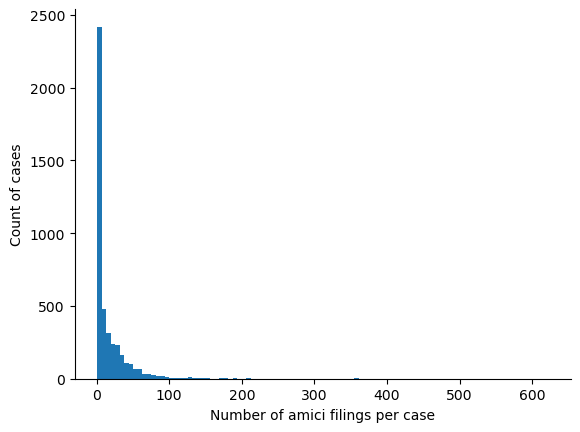

In [462]:
plt.hist(df["num_amici"], bins=100)
plt.ylabel("Count of cases")
plt.xlabel("Number of amici filings per case");

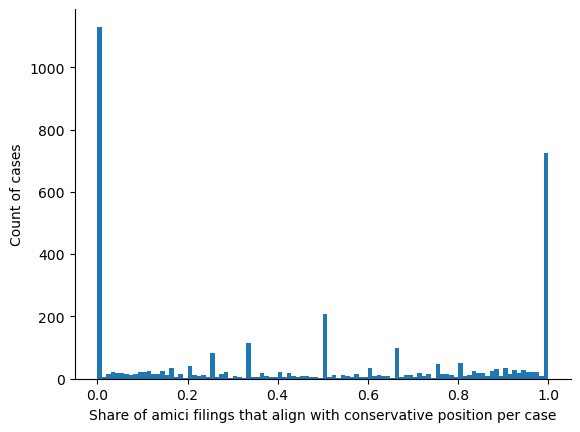

In [463]:
plt.hist(df["percent_conservative"], bins=100)
plt.ylabel("Count of cases")
plt.xlabel("Share of amici filings that align with conservative position per case");

In [464]:
(df["distinct_amicus_positions"] == 1).mean()
# in about 45% of cases all amici share the same position

0.4544424297370807

In [465]:
df["percent_conservative"].isna().mean()

0.16613780598368086

In [466]:
# cut down cases with 1
(df["num_amici"] == 1).mean()

0.20126926563916592

## Check Distribution of Amici Directions

* Additionally, check consistency of amici directions (are they always advocating for the same direction or does it switch frequently)

In [467]:
# create a dataframe of all amicus positions for each case
# we want to look at the direction of each position across all cases
# and then we want to identify "conservative" amici as a static filter
amici_cases = []
for lexis_cite, docket in preproc_data.items():
    amicus_case_data = {"lexisCite": lexis_cite}
    for amicus in docket["amici"]:
        # identify the ideological direction of the amicus brief based on its relationship with the disposition
        # and the disposition direction
        amicus_direction = amicusDirection(
            amicus[1], docket["case_decision"], docket["decisiondirection"]
        )
        
        amicus_case_data['amicus'] = amicus[0]
        amicus_case_data['position'] = amicus[1]
        amicus_case_data['direction'] = amicus_direction
        
    amici_cases += [amicus_case_data]

amicus_direction_data = pd.DataFrame(amici_cases)
amicus_direction_data.head()

,lexisCite,amicus,position,direction
0,1953 U.S. LEXIS 2673,SECURITIES AND EXCHANGE COMMISSION,1,2
1,1953 U.S. LEXIS 2680,BOSTON AMERICAN LEAGUE BASE BALL COMPANY,2,1
2,1954 U.S. LEXIS 2094,CONGRESS OF INDUSTRIAL ORGANIZATIONS,1,1
3,1954 U.S. LEXIS 2095,AMERICAN COUNCIL ON HUMAN RIGHTS,1,1
4,1954 U.S. LEXIS 2336,SECURITIES AND EXCHANGE COMMISSION,2,2


In [468]:
amicus_direction_data['direction'].value_counts(normalize=True)

direction
2     0.496147
1     0.402765
99    0.101088
Name: proportion, dtype: float64

In [469]:
amicus_direction_data = amicus_direction_data[amicus_direction_data['direction'] != 99]

In [470]:
direction_by_amicus = amicus_direction_data.groupby('amicus')['direction'].apply(lambda x: len(np.unique(x))).to_frame()
(direction_by_amicus['direction'] > 1).mean()

0.14712005551700208

In [471]:
direction_by_amicus['direction'].value_counts(normalize=True)

direction
1    0.85288
2    0.14712
Name: proportion, dtype: float64

Text(0.5, 0, 'Percent of cases with a given direction per amicus')

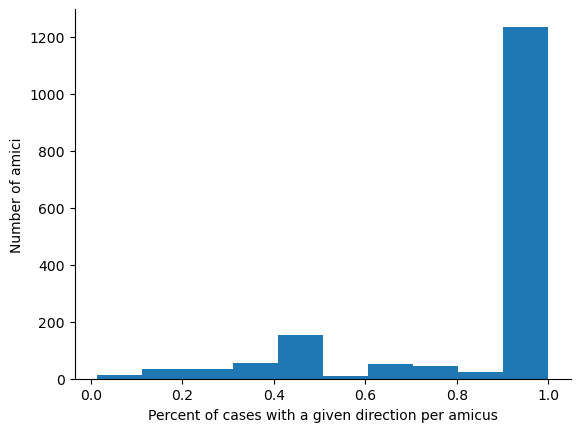

In [472]:
plt.hist((amicus_direction_data[['amicus', 'direction']].value_counts() / amicus_direction_data['amicus'].value_counts()).sort_index())
plt.ylabel('Number of amici')
plt.xlabel('Percent of cases with a given direction per amicus')

In [473]:
directions_per_amicus = amicus_direction_data[['amicus', 'direction']].value_counts().to_frame()
directions_per_amicus.loc[directions_per_amicus.groupby('amicus')['count'].idxmax()].shape

(1441, 1)

In [474]:
amicus_direction_data['amicus'].value_counts().shape

(1441,)

In [475]:
amicus_direction_mgd = pd.merge(directions_per_amicus.loc[directions_per_amicus.groupby('amicus')['count'].idxmax()]\
                                .rename({'count':'count_top_amicus'}, axis=1),  \
  amicus_direction_data['amicus'].value_counts().to_frame(), on = 'amicus')
amicus_direction_mgd['percent'] = amicus_direction_mgd['count_top_amicus']/amicus_direction_mgd['count']
(amicus_direction_mgd['percent'] > 0.9).mean()

0.8577376821651631

#

## Apply additional filters, check dist
* Drop cases with only 1 amicus
* Drop cases with any amicus that has a missing value for conservative
* Drop cases with unspecifiable decision direction

In [476]:
df.loc[df["percent_conservative"].isna()]

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions,num_amici
1954 U.S. LEXIS 2621,FEDERAL POWER COMMISSION v. NIAGARA MOHAWK POW...,"[(HLBlack, 2.0, 2.0), (WODouglas, 2.0, 2.0), (...",2.0,1.0,"[(NEW YORK, 3)]",[nan],NaN,1,1
1954 U.S. LEXIS 2690,RADIO OFFICERS' UNION OF THE COMMERCIAL TELEGR...,"[(HLBlack, 2.0, 2.0), (WODouglas, 2.0, 2.0), (...",2.0,1.0,[(NEWSPAPER AND MAIL DELIVERERS UNION OF NEW Y...,[nan],NaN,1,1
1955 U.S. LEXIS 1186,TEE-HIT-TON INDIANS v. UNITED STATES,"[(HLBlack, 1.0, 2.0), (WODouglas, 2.0, 1.0), (...",2.0,2.0,"[(IDAHO, 3), (UTAH, 1), (NEW MEXICO, 3)]","[nan, True, nan]",NaN,2,3
1955 U.S. LEXIS 734,BROWN et al. v. BOARD OF EDUCATION OF TOPEKA e...,"[(JHarlan2, 1.0, 2.0), (HLBlack, 1.0, 2.0), (W...",4.0,2.0,"[(NORTH CAROLINA, 3), (UNITED STATES, 3), (MAR...","[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,1,8
1956 U.S. LEXIS 1803,"DE SYLVA v. BALLENTINE, GUARDIAN","[(JHarlan2, 1.0, 2.0), (HLBlack, 4.0, 2.0), (W...",2.0,2.0,"[(REGISTER OF COPYRIGHTS, 3), (SONGWRITERS GUI...","[nan, True, True, True, True]",NaN,2,5
...,...,...,...,...,...,...,...,...,...
2014 U.S. LEXIS 4496,"AMERICAN BROADCASTING COS. v. AEREO, INC.","[(JGRoberts, 1.0, 1.0), (AScalia, 2.0, 2.0), (...",4.0,1.0,"[(MEDIA INSTITUTE, 1), (MAJOR LEAGUE BASEBALL,...","[True, True, True, True, True, True, True, Tru...",NaN,3,81
2014 U.S. LEXIS 4499,MCCULLEN v. COAKLEY,"[(JGRoberts, 1.0, 1.0), (AScalia, 4.0, 1.0), (...",4.0,1.0,"[(CENTER FOR CONSTITUTIONAL JURISPRUDENCE, 1),...","[True, True, True, True, True, True, True, Tru...",NaN,3,174
2014 U.S. LEXIS 4504,HARRIS v. QUINN,"[(JGRoberts, 1.0, 1.0), (AScalia, 1.0, 1.0), (...",7.0,1.0,"[(ILLINOIS POLICY INSTITUTE, 1), (CATO INSTITU...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,2,81
2014 U.S. LEXIS 4505,BURWELL v. HOBBY LOBBY STORES,"[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",2.0,2.0,"[(INDIVIDUAL RIGHTS FOUNDATION, 2), (PACIFIC L...","[False, False, False, False, False, nan, nan, ...",NaN,3,356


In [477]:
(
    (df["num_amici"] == 1)
    | (df["decisiondirection"] == 3)
    | (df["percent_conservative"].isna())
    | (df['percent_conservative']>=1)
    | (df['percent_conservative']<=0)
).mean()
# we are dropping ~59% of the data

0.5861287398005439

In [478]:
assert df.index.unique().shape[0] == df.shape[0]

In [479]:
df_filt = df[
    ~(
        (df["num_amici"] == 1)
        | (df["decisiondirection"] == 3)
        | (df["percent_conservative"].isna())
    )
]

# exclude cases where amici are all in agreement
df_filt = df_filt.loc[(df_filt['percent_conservative']<1) & (df_filt['percent_conservative']>0)]

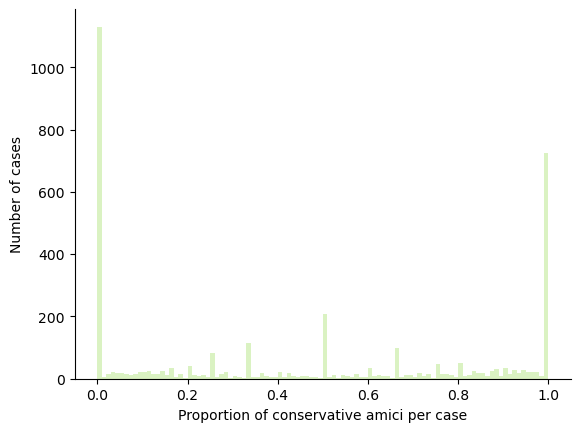

In [697]:
plt.hist(df["percent_conservative"], bins=100, color=green_fill)
plt.ylabel("Number of cases")
plt.xlabel("Proportion of conservative amici per case")
plt.savefig('./plots/conservative_proportion_fulldata.pdf');

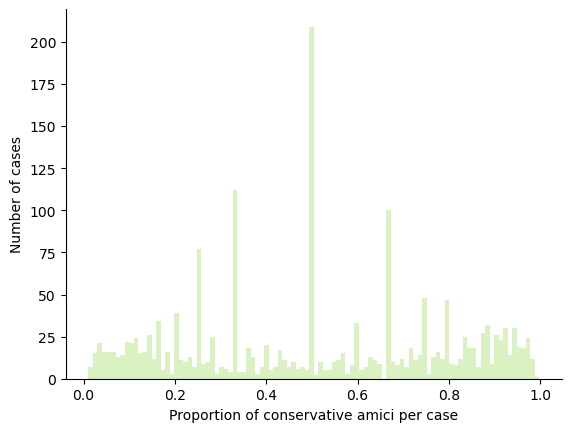

In [698]:
plt.hist(df_filt["percent_conservative"], bins=100, color=green_fill)
plt.ylabel("Number of cases")
plt.xlabel("Proportion of conservative amici per case")
plt.savefig('./plots/conservative_proportion_filtered.pdf');

In [481]:
df_filt['case_name'].index.shape

(1826,)

## Apply Threshold Algorithm

In [482]:
# swing vote justices
# pick one extreme and one expected moderate
# SAAlito, JGRoberts, SSotomayor

# other options
# JGRoberts
# DHSouter
# SAAlito
# AScalia
# CThomas
# SSotomayor
# EKagan

selected_judge = "SSotomayor"
final_justices;

In [483]:
def filterJudgeData(df, justice_df, selected_judge):
    # select data with which the judge has been a decision-maker
    sel_cases_justice = justice_df.loc[justice_df["justiceName"] == selected_judge]

    if sel_cases_justice["lexisCite"].unique().shape[0] != sel_cases_justice.shape[0]:
        print(sel_cases_justice["lexisCite"].unique().shape[0])
        print(sel_cases_justice.shape[0])

    # merge selected cases where judge was a decision-maker back onto the original data
    df_selected = pd.merge(
        df.reset_index(drop=False).rename({"index": "lexisCite"}, axis=1)[
            [
                "lexisCite",
                "conservative_amici",
                "amici",
                "percent_conservative",
                "distinct_amicus_positions",
                "num_amici",
            ]
        ],
        sel_cases_justice[["lexisCite", "vote", "direction", "decisionDirection"]],
        on="lexisCite",
        how="inner",
    )

    # check for uniqueness
    assert df_selected["lexisCite"].unique().shape[0] == df_selected.shape[0]
    # determine whether the judges vote was conservative
    # based on the judges direction of the vote
    df_selected["conservative_vote"] = np.select(
        [
            df_selected["direction"] == 1,
            df_selected["direction"] == 2,
            df_selected["direction"] == 3,
        ],
        [1, 0, np.nan],
    )

    return df_selected


df_selected = filterJudgeData(df_filt, justices_csv, selected_judge)
df_selected.head()

,lexisCite,conservative_amici,amici,percent_conservative,distinct_amicus_positions,num_amici,vote,direction,decisionDirection,conservative_vote
0,2009 U.S. LEXIS 8941,"[False, False, False, False, False, False, Fal...","[(WOMEN'S CRIMINAL DEFENSE BAR ASSOCIATION, 2)...",0.771429,2,35,1.0,1.0,1.0,1.0
1,2009 U.S. LEXIS 8942,"[True, False, False, False]","[(UNITED STATES, 2), (DRI -- THE VOICE OF THE ...",0.250000,2,4,1.0,1.0,1.0,1.0
2,2009 U.S. LEXIS 8943,"[False, False, True, True, True]",[(BROTHERHOOD OF LOCOMOTIVE ENGINEERS AND TRAI...,0.600000,2,5,1.0,2.0,2.0,0.0
3,2010 U.S. LEXIS 1,"[False, False, False, False, False, True, True...","[(BLACK COPS AGAINST POLICE BRUTALITY, 2), (CE...",0.883721,2,43,1.0,1.0,1.0,1.0
4,2010 U.S. LEXIS 1897,"[True, False, False, False, False]","[(LEGAL AID SOCIETY, EMPLOYMENT LAW CENTER, 2)...",0.200000,2,5,1.0,2.0,2.0,0.0


In [484]:
assert df_selected["percent_conservative"].isna().sum() == 0

In [485]:
def learningThresholds(judge_name, df, iter=100):
    # initialize lower and upper bounds of thresholds
    judge_threshold_min = [0]
    judge_threshold_max = [1]

    observed_thresholds = []
    cons_votes = []
    for i in range(iter):
        if i >= df.shape[0]:
            continue
        case_selection = df.sort_values("lexisCite").iloc[i, :]
        observed_threshold = case_selection["percent_conservative"]
        judge_vote = case_selection["conservative_vote"]
        if judge_vote == 0:
            judge_threshold_min += [max(observed_threshold, max(judge_threshold_min))]
            judge_threshold_max += [min(judge_threshold_max)]
            cons_votes += [False]
        else:
            judge_threshold_min += [max(judge_threshold_min)]
            judge_threshold_max += [min(observed_threshold, min(judge_threshold_max))]
            cons_votes += [True]
        observed_thresholds += [observed_threshold]

    return (judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes)

In [486]:
def plotAmicusThresholds(df, selected_judge, weighted=False):
    df = df.sort_values('observed_thresholds', ascending=False).reset_index(drop=True)
    if weighted==True:
        w_lab = 'weighted'
    else:
        w_lab = 'unweighted'
    # plot data of thresholds
    plt.scatter(df.loc[df['votes']==True].index,
                df.loc[df['votes']==True, 'observed_thresholds'],
            color = red_fill)
    plt.scatter(df.loc[df['votes']==False].index,
                df.loc[df['votes']==False, 'observed_thresholds'],
                color = green_fill,
                alpha=1)
    plt.legend(["conservative", "liberal"], bbox_to_anchor=(0.7, -0.15))
    plt.xticks(
        np.arange(0, len(judge_threshold_min), np.round(len(judge_threshold_min) / 10, -1))
    )
    plt.ylabel('Threshold (share conservative amici positions)')
    plt.xlabel('Number of cases observed')
    plt.savefig(f'./plots/{selected_judge}_{w_lab}_threshold.pdf', bbox_inches='tight')

In [487]:
judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes = learningThresholds(
    selected_judge, df_selected
)

df_plot = pd.DataFrame({'observed_thresholds': observed_thresholds, 'votes': cons_votes})
df_plot.sort_values('observed_thresholds', ascending=False).head()

,observed_thresholds,votes
27,0.978723,True
6,0.975000,True
49,0.973684,True
28,0.972222,False
72,0.968750,True


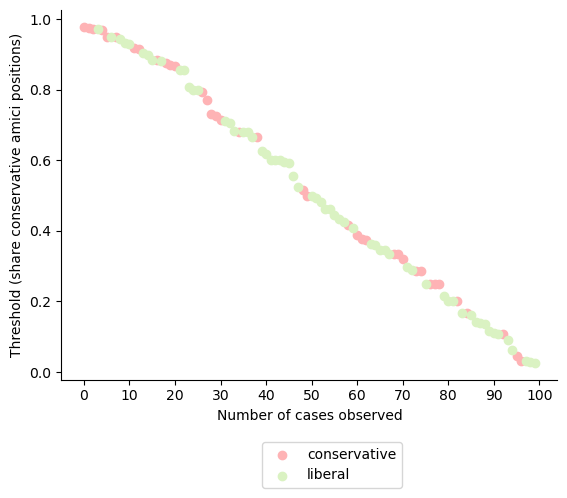

In [488]:
plotAmicusThresholds(df_plot, selected_judge)

In [489]:
# investigate contradictory cases
print(df_selected.loc[(df_selected['percent_conservative'] < 0.1) & (df_selected['direction']==1)].shape)
cases_sotomayor = df_selected.loc[(df_selected['percent_conservative'] < 0.1) & (df_selected['direction']==1), 'lexisCite']
df_selected.loc[(df_selected['percent_conservative'] < 0.1) & (df_selected['direction']==1)]

(5, 10)


,lexisCite,conservative_amici,amici,percent_conservative,distinct_amicus_positions,num_amici,vote,direction,decisionDirection,conservative_vote
11,2010 U.S. LEXIS 2927,"[True, True, False, False, False, False, False...","[(AMERICAN CENTER FOR LAW AND JUSTICE, 2), (UN...",0.045455,2,44,2.0,1.0,2.0,1.0
55,2011 U.S. LEXIS 2593,"[False, False, False, False, False, False, Fal...","[(UNITED STATES, 2), (CRIMINAL JUSTICE LEGAL F...",0.032258,2,31,1.0,1.0,1.0,1.0
122,2013 U.S. LEXIS 1612,"[False, False, False, False, False, False, Fal...",[(INTELLECTUAL PROPERTY LAW ASSOCIATION OF CHI...,0.090909,2,11,1.0,1.0,1.0,1.0
137,2013 U.S. LEXIS 3317,"[True, True, True, True, False, False, False, ...","[(VIRGINIA ASSOCIATION OF COUNTIES, 2), (VIRGI...",0.045455,2,88,1.0,1.0,1.0,1.0
153,2013 U.S. LEXIS 4701,"[False, False, False, False, False, False, Fal...","[(HISPANIC NATIONAL BAR ASSOCIATION, 2), (NATI...",0.040193,2,622,1.0,1.0,1.0,1.0


In [490]:
# list of lists of directions of each justice in cases where sotomayor voted conservatively
[[y[2] for y in x] for x in df_filt.loc[df_filt.index.isin(cases_sotomayor), 'justices']]

[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, nan]]

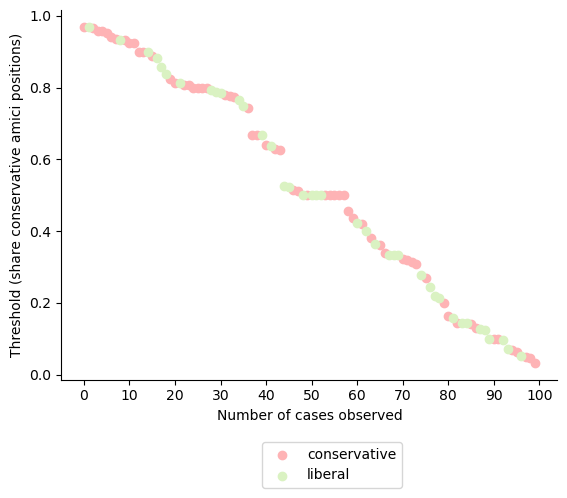

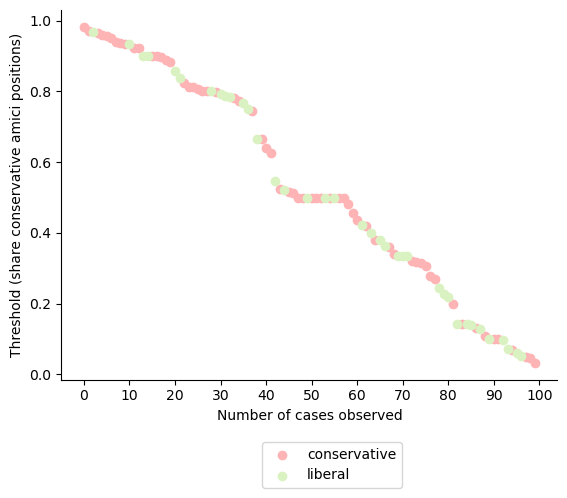

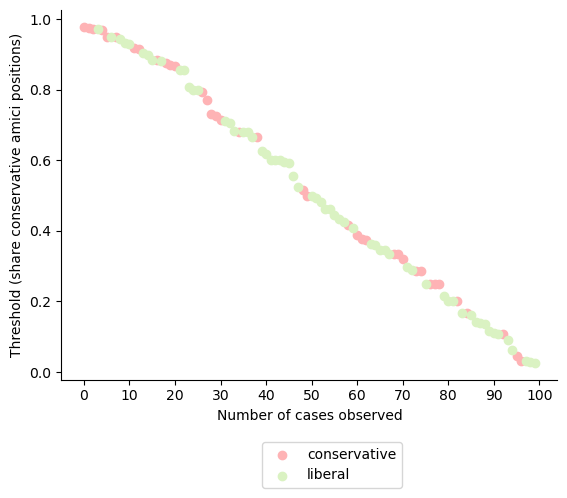

In [491]:
# learn thresholds for each justice using the filtered data
for i in ['SAAlito', 'JGRoberts', 'SSotomayor']:
    # identify cases for only this justice
    df_selected = filterJudgeData(df_filt, justices_csv, i)
    df_selected = df_selected[(df_selected['percent_conservative'] < 1) & (df_selected['percent_conservative'] > 0)]
    # learn the threshold (i.e., apply the threshold alg)
    judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes = learningThresholds(i, df_selected)

    # plot data
    df_plot = pd.DataFrame({'observed_thresholds': observed_thresholds, 'votes': cons_votes})
    plotAmicusThresholds(df_plot, i)
    plt.show();

## Learning Weights

This is a simple baseline model where we infer the weights based on past agreement of amicus and justice

In [492]:
# we need a matrix representing each amicus as 1, 0, -1
amici_cases = []
justice_cases = []
for lexis_cite, docket in preproc_data.items():
    # only include cases in previously filtered data
    if lexis_cite not in df_filt.index:
        continue

    amicus_case_data = {"lexisCite": lexis_cite}
    justice_case_data = {"lexisCite": lexis_cite}
    for amicus in docket["amici"]:
        # identify the ideological direction of the amicus brief based on its relationship with the disposition
        # and the disposition direction
        amicus_direction = amicusDirection(
            amicus[1], docket["case_decision"], docket["decisiondirection"]
        )
        if amicus_direction == 1:
            amicus_case_data[amicus[0]] = 1
        elif amicus_direction == 2:
            amicus_case_data[amicus[0]] = -1
        else:
            amicus_case_data[amicus[0]] = 0
    amici_cases += [amicus_case_data]

    for justice in docket["justices"]:
        # identify the ideological direction of the justice
        # 1 is conservative
        if justice[2] == 1:
            justice_case_data[justice[0]] = 1
        elif justice[2] == 2:
            # 2 is liberal
            justice_case_data[justice[0]] = -1
        else:
            # unspecified
            justice_case_data[justice[0]] = 0
    justice_cases += [justice_case_data]

In [493]:
# amici that don't sign on to a case should be neutral (i.e. = 0)
# why are we replacing na with 0? This feels like it should be preprocessed better but we can fix after
X = pd.DataFrame(amici_cases).fillna(0)
X = X[(X != 99).all(axis=1)]
X.shape, df_filt.shape

((1826, 13735), (1826, 9))

In [494]:
# let's get the actual decisions
# if they didn't rule on the case they should be neutral (or they should be missing?)
y = pd.DataFrame(justice_cases).fillna(0) # unspecified so they're neutral
y = pd.merge(y, X['lexisCite'], on='lexisCite', how='inner')

np.array(y.drop('lexisCite', axis=1)).shape
y.shape

(1826, 34)

In [495]:
amici_cols = [x for x in X.columns if x != 'lexisCite']
X_comp = pd.merge(X, y, on='lexisCite').copy().sort_values('lexisCite')
X_comp = pd.concat([X_comp[amici_cols]\
                    .rename(lambda x: x + '_agree', axis=1), X_comp], axis=1)
X_comp = X_comp.loc[X_comp[selected_judge] != 0].reset_index(drop=True)

In [496]:
for i in amici_cols:
    X_comp[i+'_agree'] = (X_comp[i] == X_comp[selected_judge]).astype(int)
    X_comp.loc[X_comp[i] == 0, i+'_agree'] = np.nan

In [497]:
X_comp[[x + '_agree' for x in amici_cols]] = X_comp[[x + '_agree' for x in amici_cols]].expanding().mean()

In [498]:
np.matmul(X_comp.iloc[1:][amici_cols].values,
          np.transpose(X_comp.iloc[1:][[x + '_agree' for x in amici_cols]].fillna(0).values)).shape

(187, 187)

## Learning Weights - Predictive Model

In [499]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

In [615]:
# (from Ritik's code below)
# so we first need to split up the data so that we have test and training, let's save about 100 cases for testing
# also, let's just filter to the 3 judges we are most interested in
X_train, X_test, y_train, y_test = train_test_split(X.drop('lexisCite', axis=1), 
                                                    y.drop('lexisCite', axis=1)[['SAAlito', 'JGRoberts', 'SSotomayor']], test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1460, 13734), (366, 13734), (1460, 3), (366, 3))

In [616]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [617]:
linreg = MultiOutputRegressor(LinearRegression()).fit(X_train_scaled, 
                                                    y_train)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [618]:
coefficients = [estimator.coef_ for estimator in linreg.estimators_]
len(coefficients), coefficients[0].shape;

In [619]:
# predict the outcomes and compare (for the test data)
y_pred = linreg.predict(X_test_scaled)
y_pred;

In [620]:
# check mse
mae_linreg = metrics.mean_absolute_error(y_test, y_pred)
mse_linreg = metrics.mean_squared_error(y_test, y_pred)
rmse_linreg = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [621]:
print('Mean Absolute Error:', mae_linreg)  
print('Mean Squared Error:', mse_linreg)  
print('Root Mean Squared Error:', rmse_linreg)

Mean Absolute Error: 6933802023.711796
Mean Squared Error: 2.188116839465956e+20
Root Mean Squared Error: 14792284608.761272


In [622]:
np.mean(y_pred[:,0]), np.min(y_pred[:,0]), np.max(y_pred[:,0])

(0.05685789598141863, -162196621480.13562, 86209525362.27597)

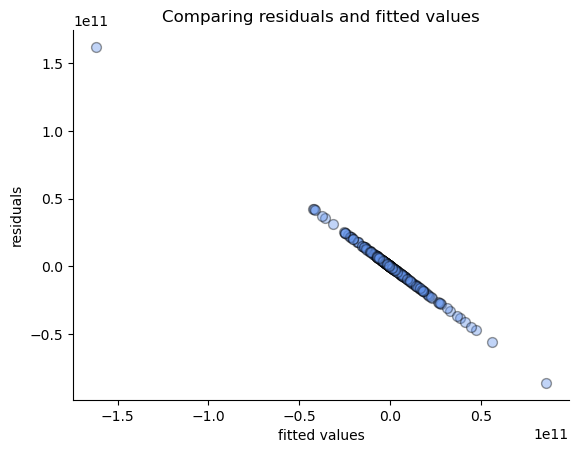

In [623]:
plt.figure()
s = 50
a = 0.4
plt.scatter(
    y_pred[:,0],
    (y_test.iloc[:,0] - y_pred[:,0]),
    edgecolor="k",
    c="cornflowerblue",
    s=s,
    alpha=a,
)

plt.xlabel("fitted values")
plt.ylabel("residuals")
plt.title("Comparing residuals and fitted values")
plt.show()

## MLP Model (Ritik's Approach)

In [624]:
# next try
mlpregr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_scaled, y_train)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [628]:
mlpregr.score(X_test_scaled, y_test)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


-1.8771372227971923

In [629]:
# Let's get predictions
y_pred = mlpregr.predict(X_test_scaled)

mae_mlp = metrics.mean_absolute_error(y_test, y_pred)
mse_mlp = metrics.mean_squared_error(y_test, y_pred)
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [630]:
print('Mean Absolute Error:', mae_mlp)  
print('Mean Squared Error:', mse_mlp)  
print('Root Mean Squared Error:', rmse_mlp)

Mean Absolute Error: 0.4356722415492112
Mean Squared Error: 0.4309318332035934
Root Mean Squared Error: 0.6564539840716891


## Ridge Regression

In [631]:
clf = Ridge()
parameters = {'alpha':[0.01, 0.05, 0.1, 0.3, 0.7, 1]}
ridgeregr = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error')
ridgeregr.fit(X_train_scaled, y_train)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.3, 0.7, 1]},
             scoring='neg_mean_squared_error')

In [632]:
# Let's get predictions
y_pred = ridgeregr.predict(X_test_scaled)

mae_ridge = metrics.mean_absolute_error(y_test, y_pred)
mse_ridge = metrics.mean_squared_error(y_test, y_pred)
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [634]:
print('Mean Absolute Error:', mae_ridge)  
print('Mean Squared Error:', mse_ridge)  
print('Root Mean Squared Error:', rmse_ridge)

Mean Absolute Error: 0.5337042818714054
Mean Squared Error: 0.7097775672153439
Root Mean Squared Error: 0.8424829774039021


## LASSO

In [635]:
clf = Lasso(tol=1e-3) # need to decrease tolerance because of convergence errors
parameters = {'alpha':[0.005, 0.01, 0.05, 0.1, 0.7]}
lassoregr = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error')
lassoregr.fit(X_train_scaled, y_train)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

GridSearchCV(estimator=Lasso(tol=0.001),
             param_grid={'alpha': [0.005, 0.01, 0.05, 0.1, 0.7]},
             scoring='neg_mean_squared_error')

In [636]:
# Let's get predictions
y_pred = lassoregr.predict(X_test_scaled)

mae_lasso = metrics.mean_absolute_error(y_test, y_pred)
mse_lasso = metrics.mean_squared_error(y_test, y_pred)
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [637]:
print(lassoregr.best_params_)
print('Mean Absolute Error:', mae_lasso)  
print('Mean Squared Error:', mse_lasso)  
print('Root Mean Squared Error:', rmse_lasso)

{'alpha': 0.05}
Mean Absolute Error: 0.18823902178764998
Mean Squared Error: 0.14956427846023668
Root Mean Squared Error: 0.38673541143815193


## PCA

In [638]:
clf = Pipeline([("pca", PCA()), ("linreg", LinearRegression())])
parameters = {'pca__n_components':[2, 5, 10, 15, 20]}
pcr = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error')
pcr.fit(X_train_scaled, y_train)

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': [2, 5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [639]:
pcr.best_params_

{'pca__n_components': 15}

In [640]:
# Let's get predictions
y_pred = pcr.predict(X_test_scaled)

mae_pcr = metrics.mean_absolute_error(y_test, y_pred)
mse_pcr = metrics.mean_squared_error(y_test, y_pred)
rmse_pcr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [641]:
print('Mean Absolute Error:', mae_pcr)
print('Mean Squared Error:', mse_pcr)  
print('Root Mean Squared Error:', rmse_pcr)

Mean Absolute Error: 0.187081406266985
Mean Squared Error: 0.1503256348643826
Root Mean Squared Error: 0.38771849951270393


## PLS

In [642]:
clf = PLSRegression()
parameters = {'n_components':[2, 5, 10, 15, 20]}
pls = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error')
pls.fit(X_train_scaled, y_train)

# Let's get predictions
y_pred = pls.predict(X_test_scaled)

mae_pls = metrics.mean_absolute_error(y_test, y_pred)
mse_pls = metrics.mean_squared_error(y_test, y_pred)
rmse_pls = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [643]:
print(pls.best_params_)
print('Mean Absolute Error:', mae_pls)
print('Mean Squared Error:', mse_pls)  
print('Root Mean Squared Error:', rmse_pls)

{'n_components': 5}
Mean Absolute Error: 0.19109844817928537
Mean Squared Error: 0.14898929790176044
Root Mean Squared Error: 0.3859913184279673


### Model Comparison

In [690]:
# create dataframe to compare outputs
model_comp = pd.DataFrame({'models': ['MLP', 'Lasso', 'Ridge', 'PCA with Lin. Regression', 'PLS'],
             'mse': [mse_mlp, mse_lasso, mse_ridge, mse_pcr, mse_pls],
             'rmse': [rmse_mlp, rmse_lasso, rmse_ridge, rmse_pcr, rmse_pls],
             'mae': [mae_mlp, mae_lasso, mae_ridge, mae_pcr, mae_pls]}).sort_values('mse', ascending=True).round(3)
model_comp

,models,mse,rmse,mae
4,PLS,0.149,0.386,0.191
1,Lasso,0.150,0.387,0.188
3,PCA with Lin. Regression,0.150,0.388,0.187
0,MLP,0.431,0.656,0.436
2,Ridge,0.710,0.842,0.534


In [691]:
print(model_comp.astype(str).to_latex())

\begin{tabular}{lllll}
\toprule
 & models & mse & rmse & mae \\
\midrule
4 & PLS & 0.149 & 0.386 & 0.191 \\
1 & Lasso & 0.15 & 0.387 & 0.188 \\
3 & PCA with Lin. Regression & 0.15 & 0.388 & 0.187 \\
0 & MLP & 0.431 & 0.656 & 0.436 \\
2 & Ridge & 0.71 & 0.842 & 0.534 \\
\bottomrule
\end{tabular}



## Redo Threshold Algorithm with Weights

In [655]:
# select best model and refit with all data
# try with PCA and lin regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop('lexisCite', axis=1))

clf_bestmodel = PLSRegression(n_components=5)
clf_bestmodel.fit(X_scaled, y.drop('lexisCite', axis=1)[['SAAlito', 'JGRoberts', 'SSotomayor']])

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

PLSRegression(n_components=5)

In [656]:
y_pred = clf_bestmodel.predict(X_scaled)
y_pred

array([[ 0.02052009,  0.01090128, -0.00603394],
       [ 0.02346561,  0.01323623, -0.00926082],
       [ 0.0377772 ,  0.0269799 , -0.0121205 ],
       ...,
       [ 0.220682  ,  0.21787814,  0.03277365],
       [ 0.07875025,  0.06689431, -0.01743959],
       [ 0.17755895,  0.18163789,  0.06997737]])

In [657]:
clf_bestmodel.coef_.shape, clf_bestmodel.intercept_.shape, X_scaled.shape

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


((13734, 3), (3,), (1826, 13734))

In [658]:
metrics.mean_squared_error(y_pred, y[['SAAlito', 'JGRoberts', 'SSotomayor']])

c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jennah\anaconda3\envs\amicus\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.09867145524695115

In [660]:
np.matmul(X_scaled, clf_bestmodel.coef_) + clf_bestmodel.intercept_ # these are the weights

array([[ 0.02050846,  0.01089061, -0.00602899],
       [ 0.02345479,  0.0132262 , -0.00925676],
       [ 0.0377703 ,  0.02697364, -0.01211722],
       ...,
       [ 0.2207252 ,  0.21792417,  0.03278923],
       [ 0.07875457,  0.06689898, -0.01743776],
       [ 0.17759033,  0.18167399,  0.07000314]])

In [661]:
def learningWeightedThresholds(judge_name, y_real, y_pred, iter=100):
    # initialize lower and upper bounds of thresholds
    judge_threshold_min = [0]
    judge_threshold_max = [1]

    observed_thresholds = []
    cons_votes = []
    print(y_real.shape)
    print(y_pred.shape)
    for i in range(min(iter, y_real.shape[0])):
        observed_threshold = y_pred[i]
        judge_vote = y_real[i]
        if judge_vote == -1:
            judge_threshold_min += [max(observed_threshold, max(judge_threshold_min))]
            judge_threshold_max += [min(judge_threshold_max)]
            cons_votes += [False]
        else:
            judge_threshold_min += [max(judge_threshold_min)]
            judge_threshold_max += [min(observed_threshold, min(judge_threshold_max))]
            cons_votes += [True]
        observed_thresholds += [observed_threshold]

    return (judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes)

In [685]:
def plotWeightedAmicusThresholds(df, selected_judge, normalize=False):
    df = df.sort_values('observed_thresholds', ascending=False).reset_index(drop=True)
    
    # plot data of thresholds
    plt.scatter(df.loc[df['votes']==True].index,
                df.loc[df['votes']==True, 'observed_thresholds'],
            color = red_fill)
    plt.scatter(df.loc[df['votes']==False].index,
                df.loc[df['votes']==False, 'observed_thresholds'],
                color = green_fill,
                alpha=1)
    plt.legend(["conservative", "liberal"], bbox_to_anchor=(0.7, -0.15))
    plt.xticks(
        np.arange(0, len(judge_threshold_min), 10)
    )
    plt.ylabel('Weighted threshold')
    plt.xlabel('Number of cases observed')
    plt.savefig(f'./plots/{selected_judge}_weighted_threshold_normalize{normalize}.pdf', bbox_inches='tight')

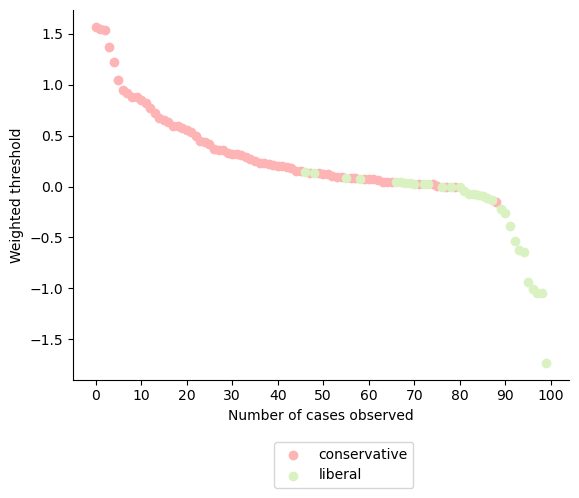

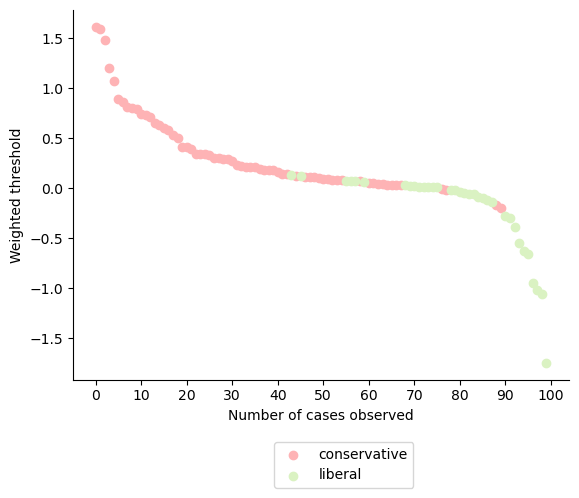

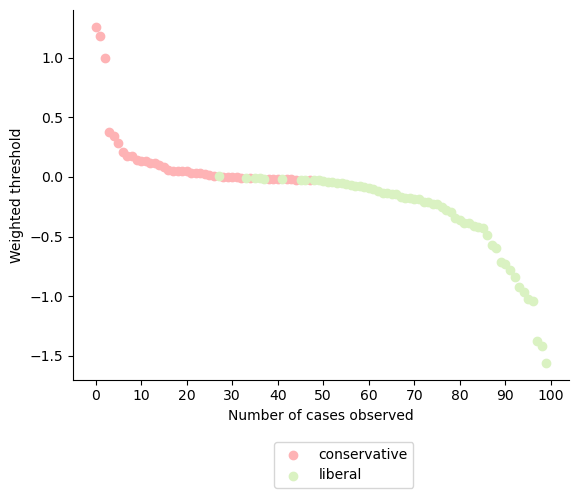

In [687]:
# learn thresholds for each of the selected justices using the filtered data
sel_justices_list = ['SAAlito', 'JGRoberts', 'SSotomayor']

for i in range(len(sel_justices_list)):
    # identify cases for only this justice
    justice_name = sel_justices_list[i]
    # learn the threshold (i.e., apply the threshold alg)
    y_real = y[justice_name][y[justice_name] != 0].values
    y_pred_justice = y_pred[:,i][y[justice_name] != 0]
    judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes = learningWeightedThresholds(i, y_real, 
                                                                                                           y_pred_justice)
    # plot data
    df_plot = pd.DataFrame({'observed_thresholds': observed_thresholds, 'votes': cons_votes})
    plotWeightedAmicusThresholds(df_plot, justice_name)
    plt.show();

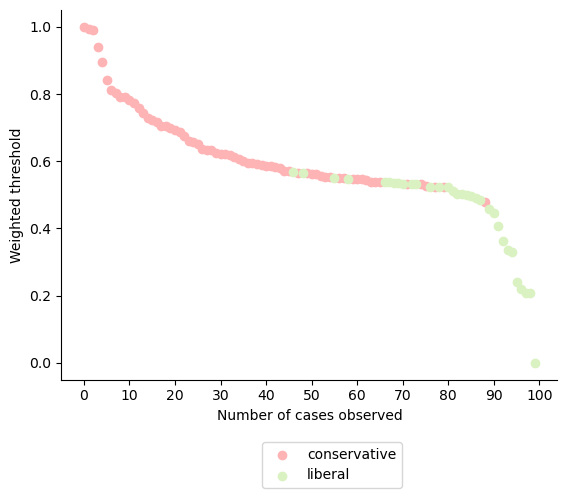

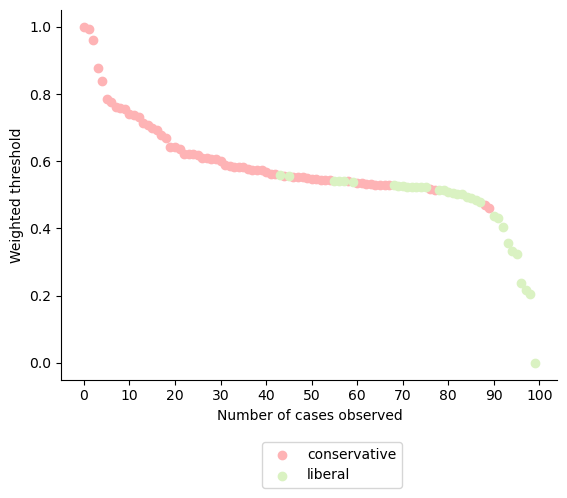

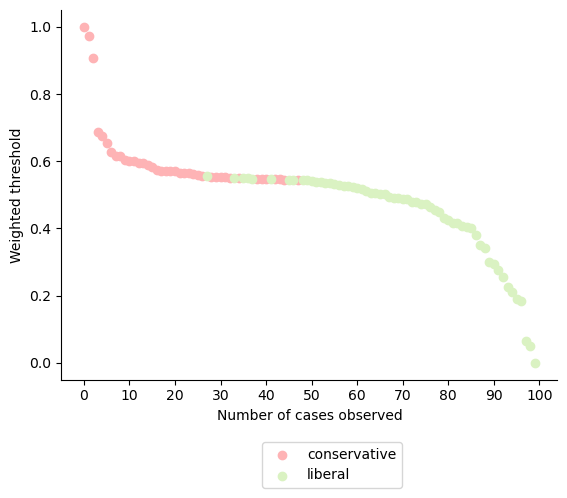

In [686]:
# learn thresholds for each of the selected justices using the filtered data
sel_justices_list = ['SAAlito', 'JGRoberts', 'SSotomayor']

for i in range(len(sel_justices_list)):
    # identify cases for only this justice
    justice_name = sel_justices_list[i]
    # learn the threshold (i.e., apply the threshold alg)
    y_real = y[justice_name][y[justice_name] != 0].values
    y_pred_justice = y_pred[:,i][y[justice_name] != 0]
    judge_threshold_min, judge_threshold_max, observed_thresholds, cons_votes = learningWeightedThresholds(i, y_real, 
                                                                                                           y_pred_justice)
    # plot data
    df_plot = pd.DataFrame({'observed_thresholds': (np.array(observed_thresholds) - \
                                                    min(np.array(observed_thresholds)))/(max(np.array(observed_thresholds))-min(np.array(observed_thresholds))), 'votes': cons_votes})
    plotWeightedAmicusThresholds(df_plot, justice_name, normalize=True)
    plt.show();